<a href="https://colab.research.google.com/github/julesripoll/dqn-pong-breakout/blob/main/Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installations

In [50]:
!pip install Pillow==9.1.1
!pip install gym==0.21
!pip install minatar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importations

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from PIL import Image
from IPython.display import display, Image as JImage
import imageio
from tqdm.notebook import tqdm
import os

## Get needed files

In [52]:
# run if on colab
!git clone https://github.com/julesripoll/dqn-pong-breakout.git
!mv dqn-pong-breakout/* .
!rm -r dqn-pong-breakout

Cloning into 'dqn-pong-breakout'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 100 (delta 35), reused 65 (delta 21), pack-reused 0
Receiving objects: 100% (100/100), 21.80 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (35/35), done.
mv: cannot move 'dqn-pong-breakout/agents' to './agents': Directory not empty
mv: cannot move 'dqn-pong-breakout/networks_weights' to './networks_weights': Directory not empty
mv: cannot move 'dqn-pong-breakout/utils' to './utils': Directory not empty


## Jupyter extensions

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Environment

In [54]:
env = gym.make('MinAtar/Breakout-v1')
env.reset();

In [55]:
from utils.utils import state_to_image

def render_env(env):
    """Needed as env.render() did not work by itself"""
    img = state_to_image(env.render('array'))
    plt.imshow(img)
    plt.show()

def render_game(frames, fps=20, show_every_x_frames=1, path='game.gif', size=200):
    processed_frames = []
    for frame in frames[::show_every_x_frames]:
        img = Image.fromarray(state_to_image(frame)).resize((size, size), Image.Resampling.NEAREST)
        processed_frames.append(np.asarray(img))
    imageio.mimwrite(path, processed_frames, fps=fps)
    display(JImage(open(path, 'rb').read()))

def play_game(env, agent=None, fps=20, show_every_x_frames=1, path='game.gif', size=200):
    frames = []
    rewards = 0
    state = env.reset()
    choose_action = lambda s: env.action_space.sample() if agent is None else agent.act(s)
    while True:
        state, r, done, _ = env.step(choose_action(state))
        frames.append(state)
        rewards += r
        if done:
            break
    render_game(frames, fps, show_every_x_frames, path, size)
    print(f"Total rewards: {rewards}")

#Explainability

## Saliency maps and gradient based methods

In [56]:
from agents.double_dqn import DoubleDQNAgent
saving_dir="./networks_weights"
#ddqn = DoubleDQNAgent(env, gamma=0.999, batch_size=256, epsilon_min=0.002, checkpoint_directory=saving_dir)

In [57]:
ddqn_name = 'DDQN_lr=1e-3_g=0.999_bs=256_em=0.002_ts=300000'
ddqn_path = os.path.join(saving_dir, ddqn_name + '.zip')
ddqn = DoubleDQNAgent.load(ddqn_path)


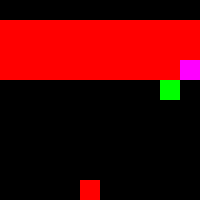

Total rewards: 28


In [58]:
play_game(env, ddqn, path='./ddqn.gif')

In [59]:
def render_game_and_saliency(frames,saliency_frames, fps=1, show_every_x_frames=1, path='saliency.gif', size=200):
    processed_sframes=[]
    processed_frames = []
    for frame in frames[::show_every_x_frames]:
        img = Image.fromarray(state_to_image(frame)).resize((size, size), Image.Resampling.NEAREST)
        processed_frames.append(np.asarray(img))
    imageio.mimwrite(path, processed_frames, fps=fps)
    for frame in saliency_frames[::show_every_x_frames]:
        img = cv2.resize(frame, (size, size))
        cv2.imwrite('tmp.png', 255*img/np.max(img))
        img=cv2.imread('tmp.png')
        processed_sframes.append(np.asarray(img))
    
    imageio.mimwrite(path, np.concatenate((processed_frames,processed_sframes), axis=2), fps=fps)
    display(JImage(open(path, 'rb').read()))


In [60]:
import torch
import cv2

def vanilla_gradient(state, model):
  state =torch.from_numpy(state).float().unsqueeze(0).cuda() # we need to set the input on GPU before the requires_grad operation!
  state.requires_grad_()
  state.retain_grad()
  action_values = model.q_network(state)
  action= action_values.argmax()#.detach().numpy())
  action=action_values[0, action]
  action.backward()
  saliency, _ = torch.max(state.grad.data.abs(), dim=1) 
  saliency = saliency.squeeze(0)
  return saliency.cpu().numpy()


def explain_game( env, agent=None, fps=20, show_every_x_frames=1, path='game_saliency.gif', size=200) :
    frames = []
    frame_saliency= []
    rewards = 0
    state = env.reset()
    choose_action = lambda s: env.action_space.sample() if agent is None else agent.act(s)
    while True:
        saliency= vanilla_gradient(state, agent)
        state, r, done, _ = env.step(choose_action(state))
        frames.append(state)
        frame_saliency.append(saliency)
        rewards += r
        if done:
            break
    render_game_and_saliency(frames, frame_saliency,fps, show_every_x_frames, path, size)
    #render_saliency(frame_saliency, fps, show_every_x_frames, 'saliency.gif', size)
    print(f"Total rewards: {rewards}")



(-0.5, 9.5, 9.5, -0.5)

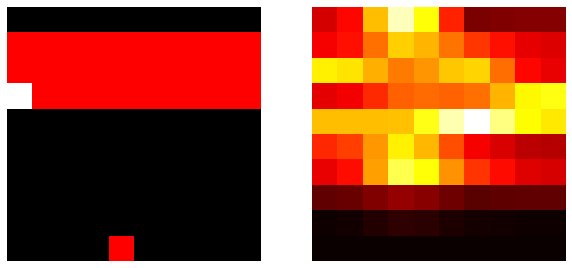

In [ ]:
state=env.reset()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(state_to_image(state))
plt.axis('off')

saliency=vanilla_gradient(state, ddqn)

plt.subplot(1,2,2)
plt.imshow(cv2.resize(saliency, (10,10)), cmap='hot')
plt.axis('off')


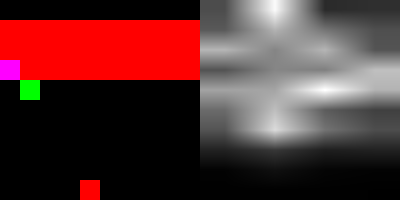

Total rewards: 24


In [61]:
explain_game( env, ddqn,fps=2)